# GO terms for differentially expressed proteins
In this notebook, we'll retrieve GO terms for proteins that are differentially expressed in the two conditions.

In [27]:
import pandas as pd
import requests, sys
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../utils/')
%load_ext autoreload
%autoreload 2
from GO_enrichment_API_functions import *
import warnings
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from matplotlib.colors import LogNorm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read in the data

In [2]:
two_vs_21 = pd.read_csv('../data/proteomics/2_vs_21_diff_abund_permutation_test_TAIR10_14Apr2025.csv', header=67)
forty_vs_21 = pd.read_csv('../data/proteomics/40_vs_21_diff_abund_permutation_test_TAIR10_14Apr2025.csv', header=67)

In [3]:
two_lfc_name = 'Log? Fold Change by Category (Set2 / Set 21)'
forty_lfc_name = 'Log? Fold Change by Category (Set 40 / Set 21)'
two_pval_col_name = "Permutation Test (p-value) Benjamini-Hochberg (p < 0.00290)"
forty_pval_col_name = "Permutation Test (p-value) Benjamini-Hochberg (p < 0.00456)"
two_pval_cutoff = 0.00290
forty_pval_cutoff = 0.00456

Basic cleaning:

In [4]:
two_vs_21[two_pval_col_name] = two_vs_21[two_pval_col_name].replace('< 0.0001', '0.00009')
forty_vs_21[forty_pval_col_name] = forty_vs_21[forty_pval_col_name].replace('< 0.0001', '0.00009')

two_vs_21[two_pval_col_name] = two_vs_21[two_pval_col_name].replace('--', np.nan)
forty_vs_21[forty_pval_col_name] = forty_vs_21[forty_pval_col_name].replace('--', np.nan)

two_vs_21[two_pval_col_name] = two_vs_21[two_pval_col_name].astype('float64')
forty_vs_21[forty_pval_col_name] = forty_vs_21[forty_pval_col_name].astype('float64')

In [5]:
print(f'Shapes of two and forty: {two_vs_21.shape}, {forty_vs_21.shape}')
two_vs_21 = two_vs_21[~two_vs_21.eq('No data').any(axis=1)]
forty_vs_21 = forty_vs_21[~forty_vs_21.eq('No data').any(axis=1)]
print(f'Shapes of two and forty after dropping No data rows: {two_vs_21.shape}, {forty_vs_21.shape}')

Shapes of two and forty: (5238, 43), (5238, 43)
Shapes of two and forty after dropping No data rows: (4464, 43), (4464, 43)


In [6]:
two_vs_21.loc[:, 'base_accession_number'] = two_vs_21['Accession Number'].str.split('.').str[0]
forty_vs_21.loc[:, 'base_accession_number'] = forty_vs_21['Accession Number'].str.split('.').str[0]

Keep only significant ones:

In [7]:
two_signif_access = two_vs_21[two_vs_21[two_lfc_name] < two_pval_cutoff]["base_accession_number"].tolist()
forty_signif_access = forty_vs_21[forty_vs_21[forty_lfc_name] < forty_pval_cutoff]["base_accession_number"].tolist()

In [10]:
data = {
    '2_vs_21': two_signif_access,
    '40_vs_21': forty_signif_access
}

conditions_semantic = {
    '2_vs_21': '2% vs. 21% oxygen at 7 hours',
    '40_vs_21': '40% vs. 21% oxygen at 7 hours'
}

## Query PANTHER

In [11]:
enrichments = defaultdict(dict)
for comp, genes in tqdm(data.items()):
    gene_list = ','.join(genes)
    enriches = {}
    for go_name, go_set in {
                            'GO%3A0008150': 'biological_process',
                            'GO%3A0003674': 'molecular_function',
                            'GO%3A0005575': 'cellular_component'
                            }.items():
        enrich_query = f'https://pantherdb.org/services/oai/pantherdb/enrich/overrep?geneInputList={gene_list}&organism=3702&annotDataSet={go_name}&enrichmentTestType=FISHER&correction=FDR&mappedInfo=COMP_LIST'
        result_json = getPANTHER(enrich_query)
        enriches[go_set] = result_json
    enrichments[comp] = enriches

100%|██████████| 2/2 [00:13<00:00,  6.91s/it]


In [13]:
go_enrichment_data = processGOenrichments(enrichments, data, conditions_semantic)
go_enrichment_data.head()


For comparison group 2% vs. 21% oxygen at 7 hours, there are...
580 biological_process GO terms
237 molecular_function GO terms
205 cellular_component GO terms
... enriched, for a total of 2083 genes in the comparison.


For comparison group 40% vs. 21% oxygen at 7 hours, there are...
579 biological_process GO terms
230 molecular_function GO terms
181 cellular_component GO terms
... enriched, for a total of 1903 genes in the comparison.



term        GOid  \
group   aspect                                                              
2_vs_21 biological_process   small molecule metabolic process  GO:0044281   
        biological_process                   cellular process  GO:0009987   
        biological_process                  metabolic process  GO:0008152   
        biological_process               biosynthetic process  GO:0009058   
        biological_process  carboxylic acid metabolic process  GO:0019752   

                              p_value_fdr  \
group   aspect                              
2_vs_21 biological_process  7.457481e-100   
        biological_process  6.806833e-100   
        biological_process   5.781599e-96   
        biological_process   4.023054e-66   
        biological_process   2.130364e-62   

                                                          associated_gene_IDs  \
group   aspect                                                                  
2_vs_21 biological_process  AT1G08490,AT4G25420,AT5G50950,AT5G14060,AT3G01...   
        biological_process  AT1G08370,AT4G25420,AT1G56450,AT2G47390,AT1G80...   
        biological_process  AT1G08370,AT4G25420,AT1G56450,AT2G47390,AT1G80...   
        biological_process  AT5G15390,AT4G25420,AT5G14060,AT1G09340,AT5G18...   
        biological_process  AT1G08490,AT4G25420,AT5G50950,AT5G14060,AT3G01...   

                           plus_minus  
group   aspect                         
2_vs_21 biological_process          +  
        biological_process          +  
        biological_process          +  
        biological_process          +  
        biological_process          +

## Plotting results

In [36]:
total_in_cat = {
    k: len(df) for k, df in data.items()
}

In [37]:
total_in_cat

{'2_vs_21': 2083, '40_vs_21': 1903}

We have to deal with rows that are underrepresented -- we didn't have any of these in the transcriptomics data, but we do here, and it throws an error if we don't deal with it.

In [44]:
underrep = go_enrichment_data[go_enrichment_data['plus_minus'] == '-']
underrep

term  \
group    aspect                                                                  
2_vs_21  biological_process                             chromosome segregation   
         biological_process        regulation of cell population proliferation   
         biological_process                               cell fate commitment   
         biological_process                                cell-cell signaling   
         biological_process                     nuclear chromosome segregation   
40_vs_21 biological_process                                    DNA replication   
         biological_process                      DNA-templated DNA replication   
         biological_process                             recombinational repair   
         biological_process  double-strand break repair via homologous reco...   
         cellular_component                    transcription regulator complex   
         cellular_component            serine/threonine protein kinase complex   
         cellular_component                             protein kinase complex   
         cellular_component  RNA polymerase II transcription regulator complex   
         molecular_function  cis-regulatory region sequence-specific DNA bi...   
         molecular_function  RNA polymerase II cis-regulatory region sequen...   

                                   GOid   p_value_fdr associated_gene_IDs  \
group    aspect                                                             
2_vs_21  biological_process  GO:0007059  1.205584e-03                 NaN   
         biological_process  GO:0042127  1.429585e-02                 NaN   
         biological_process  GO:0045165  2.006483e-02                 NaN   
         biological_process  GO:0007267  2.834322e-02                 NaN   
         biological_process  GO:0098813  2.831409e-02                 NaN   
40_vs_21 biological_process  GO:0006260  3.785401e-03                 NaN   
         biological_process  GO:0006261  3.056051e-02                 NaN   
         biological_process  GO:0000725  3.156709e-02                 NaN   
         biological_process  GO:0000724  4.489873e-02                 NaN   
         cellular_component  GO:0005667  3.188073e-04                 NaN   
         cellular_component  GO:1902554  1.699425e-02                 NaN   
         cellular_component  GO:1902911  1.762770e-02                 NaN   
         cellular_component  GO:0090575  1.806907e-02                 NaN   
         molecular_function  GO:0000987  2.139154e-07                 NaN   
         molecular_function  GO:0000978  8.411027e-06                 NaN   

                            plus_minus  
group    aspect                         
2_vs_21  biological_process          -  
         biological_process          -  
         biological_process          -  
         biological_process          -  
         biological_process          -  
40_vs_21 biological_process          -  
         biological_process          -  
         biological_process          -  
         biological_process          -  
         cellular_component          -  
         cellular_component          -  
         cellular_component          -  
         cellular_component          -  
         molecular_function          -  
         molecular_function          -

In [22]:
go_enrichment_data_over = go_enrichment_data[go_enrichment_data['plus_minus'] == '+']

In [38]:
go_enrichment_data_over['count'] = go_enrichment_data_over['associated_gene_IDs'].str.split(',').apply(len)
go_enrichment_data_over['category_total'] = go_enrichment_data_over.index.get_level_values(0).map(total_in_cat)
go_enrichment_data_over['gene_ratio'] = go_enrichment_data_over['count']/go_enrichment_data_over['category_total']

In [39]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    # Plotting code adapted from https://github.com/gingraslab/go_terms_dot_plot/blob/main/src/go_terms_dot_plot.py
    # -------------------------------------------------------------------------------------------------------------
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

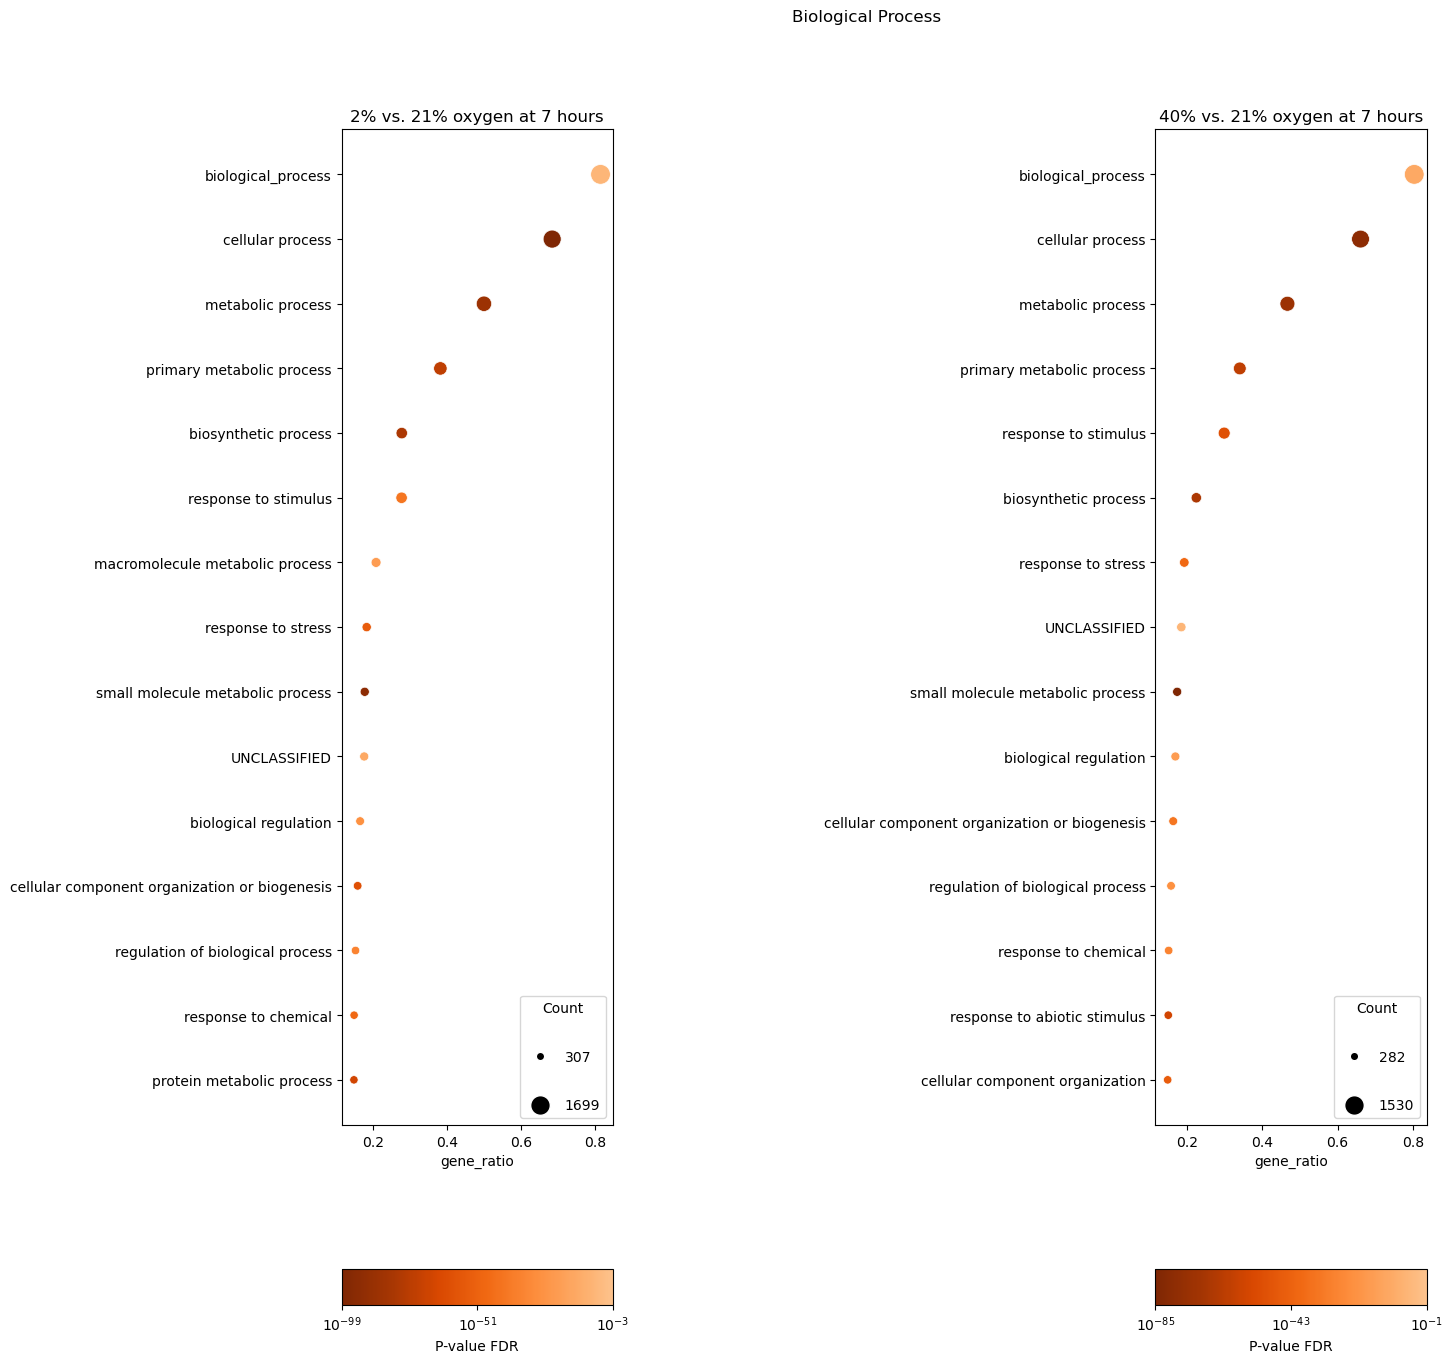

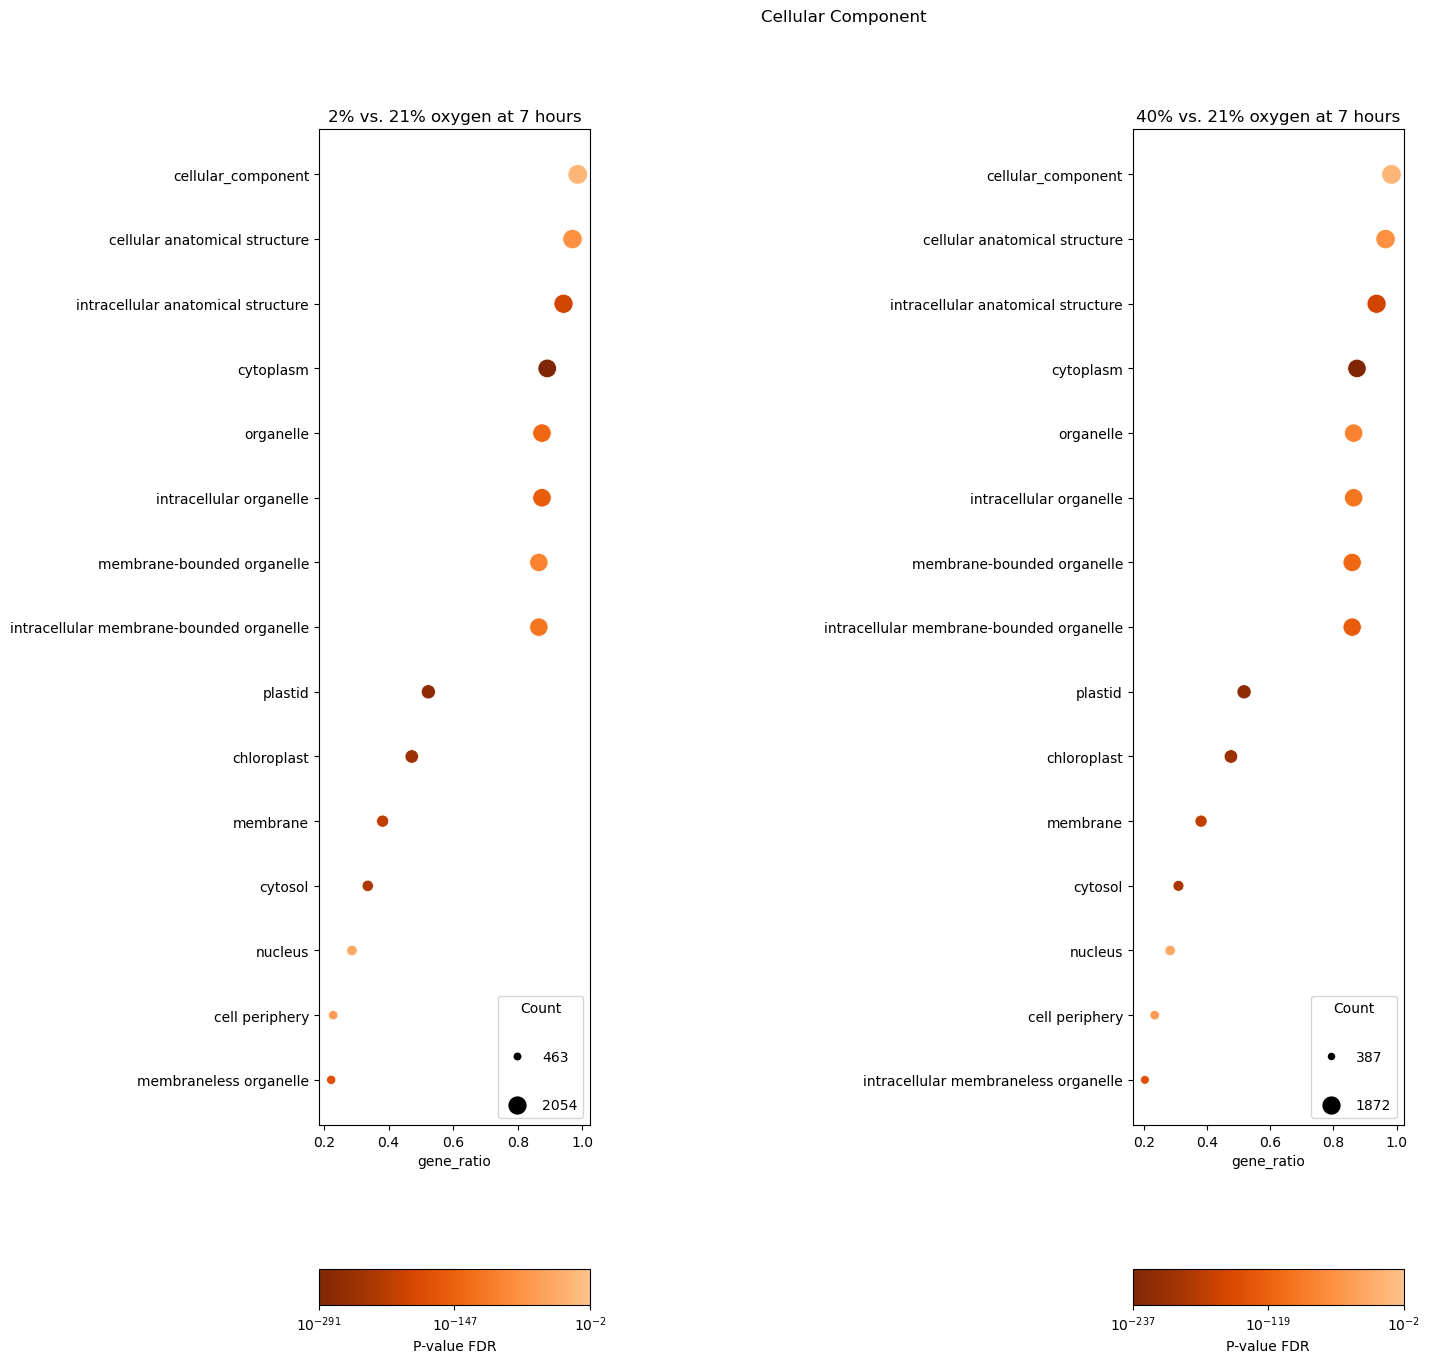

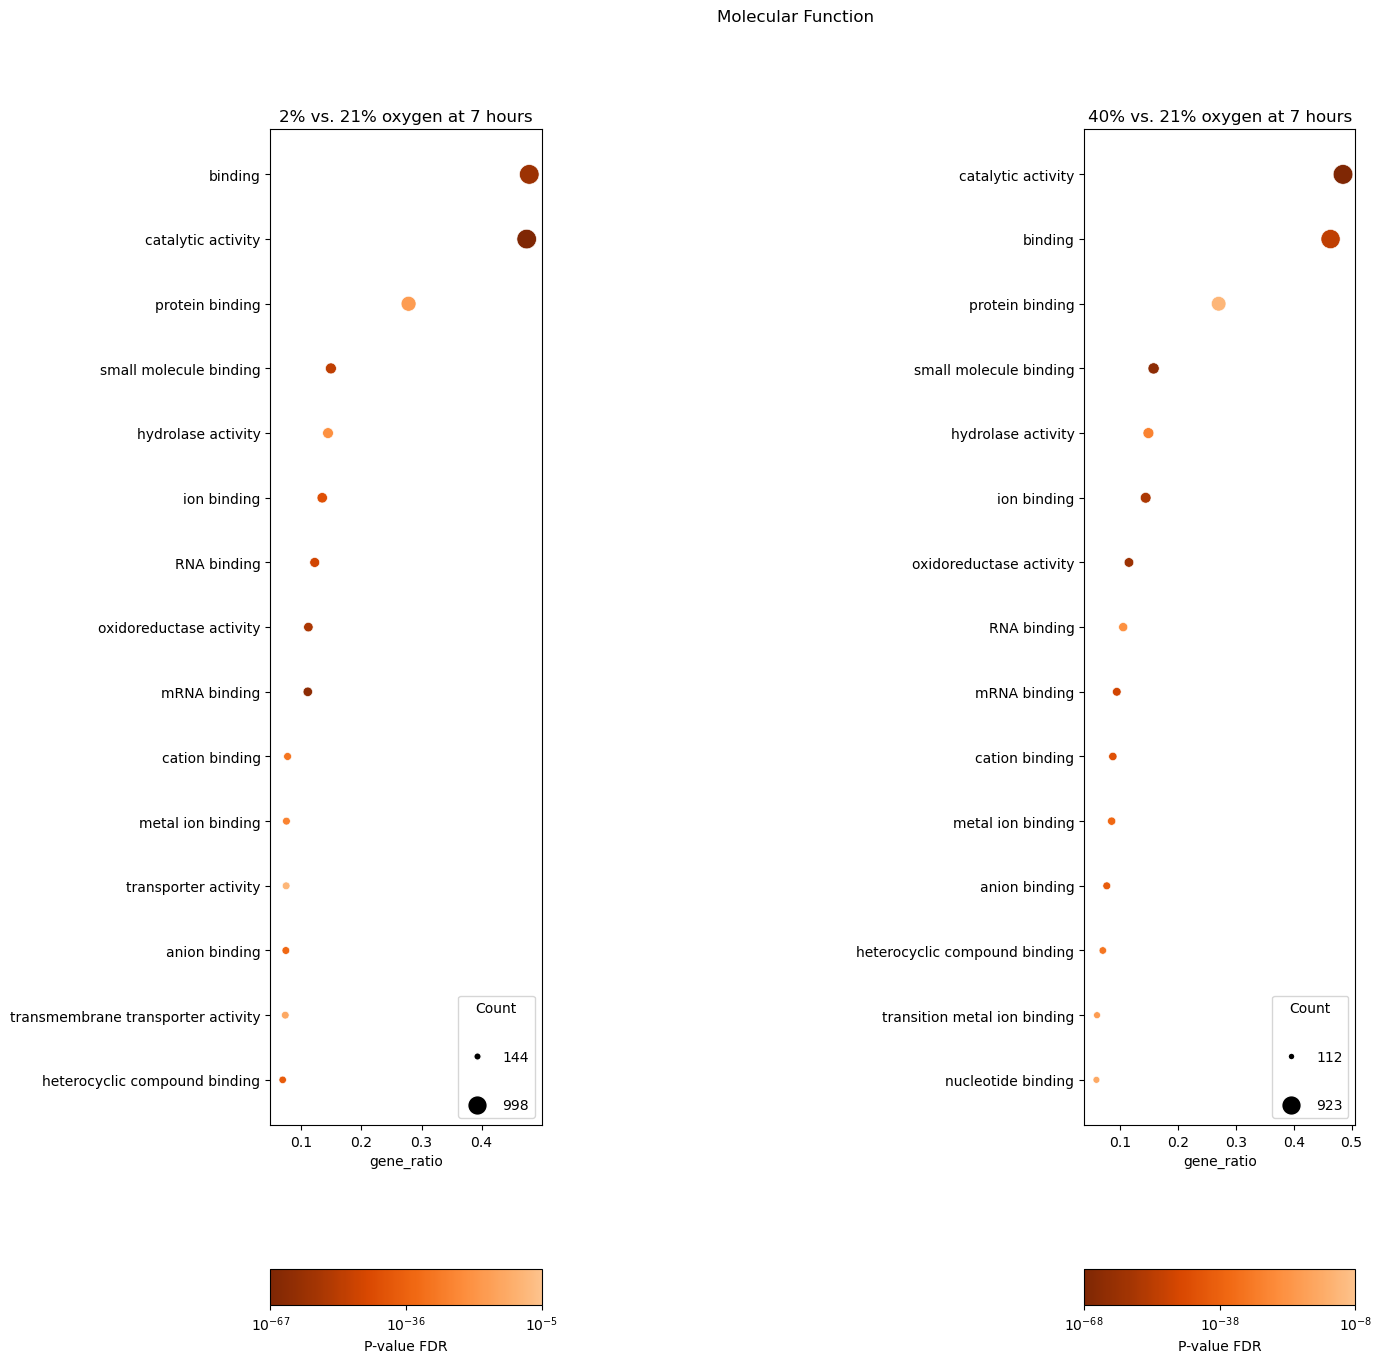

In [43]:
warnings.filterwarnings('ignore')
for aspect in ['biological_process', 'cellular_component', 'molecular_function']:

    fig, axs = plt.subplots(1, len(data), figsize=(len(data)*7, 12))

    for ax, comparison in zip(axs.flat, go_enrichment_data_over.index.get_level_values(0).unique()):

        # Get data to plot
        try:
            sub_to_plot = go_enrichment_data_over.loc[(comparison, aspect), :].sort_values(by='gene_ratio', ascending=False).iloc[:15, :]
        except KeyError:
            ax.remove()
            continue

        # Plotting code adapted from https://github.com/gingraslab/go_terms_dot_plot/blob/main/src/go_terms_dot_plot.py
        # -------------------------------------------------------------------------------------------------------------
        # Create colormap
        cmap = cm.get_cmap('Oranges_r')
        cmap = truncate_colormap(cmap, 0.0, 0.7)

        # Map p-values to colormap
        color_dict = {p: cmap(i/15) for i, p in enumerate(sorted(sub_to_plot['p_value_fdr'].unique()))}

        # Calculate scaled sizes for the plot
        max_size = sub_to_plot['count'].max()
        sub_to_plot['scaled_count'] = (sub_to_plot['count'] / max_size) * 200  # Scale sizes proportionally
        
        # Create a sizes dictionary that maps every unique scaled size to a specific plot size
        unique_scaled_sizes = sub_to_plot['scaled_count'].unique()
        sizes_dict = {size: size for size in unique_scaled_sizes}
    
        # Create the scatter plot using the sizes dictionary
        sns.scatterplot(x='gene_ratio', y='term', size='scaled_count', hue='p_value_fdr',
                        data=sub_to_plot, palette=color_dict, sizes=sizes_dict, ax=ax)
        ax.set(ylabel=None)
    
        # Calculate the smallest and largest sizes for the legend
        smallest_size_scaled = sub_to_plot['scaled_count'].min()
        largest_size_scaled = sub_to_plot['scaled_count'].max()
    
        # Create size legend with exact plot sizes
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                      markersize=np.sqrt(size),  # Convert area size to diameter
                                      markerfacecolor='black', label=f'{int(sub_to_plot[sub_to_plot["scaled_count"] == size]["count"].iloc[0])}') 
                          for size in [smallest_size_scaled, largest_size_scaled]]
        lgd = ax.legend(handles=legend_elements, title='Count', loc='lower right', labelspacing=2.5)
    
        # Get the minimum and maximum adjusted p-values
        min_p = sub_to_plot['p_value_fdr'].min()
        max_p = sub_to_plot['p_value_fdr'].max()
    
        # Create a logarithmic normalization object based on these values
        norm = LogNorm(vmin=min_p, vmax=max_p)
    
        # Calculate the middle value for the p-value range on a log scale
        middle_p = np.sqrt(min_p * max_p)
    
        # Create colorbar with three ticks: min, middle, and max p-values
        fig.subplots_adjust(bottom=0.05, wspace=2)
        
        cax = fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.15, ax.get_position().width, 0.03])
        if len(sub_to_plot) > 3: # Specific to my data
            cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal', 
                            ticks=[min_p, middle_p, max_p])
        else:
            cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal', 
                            ticks=[min_p, middle_p, max_p])
        cb.set_label('P-value FDR')
    
        # Set the tick labels, using scientific notation
        cb.ax.set_xticklabels([f'$10^{{{int(np.log10(t))}}}$' for t in [min_p, middle_p, max_p]])
        # print([f'$10^{{{int(np.log10(t))}}}$' for t in [min_p, middle_p, max_p]])

        ax.set_title(conditions_semantic[comparison])

    fig.suptitle(' '.join(aspect.split('_')).title())
    plt.savefig(f'../data/Araport11_outputs_ALL/figures/protein_GO_aspect_{aspect}_05May2025.png', format='png', dpi=600, bbox_inches='tight')